In [31]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [32]:
# import the covid date csv & clean
covid_df= pd.read_csv('United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv',thousands=',', parse_dates=[0])
covid_df.drop(['consent_cases', 'consent_deaths', 'created_at', 'conf_cases','prob_cases', 'conf_death','pnew_case','prob_death', 'pnew_death'], axis= 1, inplace = True)
covid_df.rename(columns={'submission_date':'Submission Date','state':'State','tot_cases':'Total Cases','new_case':'Daily New Cases','tot_death':'Total Deaths','new_death': 'Daily New Deaths'}, inplace = True)

covid_df.sort_values(['State','Submission Date'])

,Submission Date,State,Total Cases,Daily New Cases,Total Deaths,Daily New Deaths
3599,2020-01-22,AK,0,0,0,0
28030,2020-01-23,AK,0,0,0,0
29871,2020-01-24,AK,0,0,0,0
29941,2020-01-25,AK,0,0,0,0
32257,2020-01-26,AK,0,0,0,0
...,...,...,...,...,...,...
15653,2021-08-23,WY,71562,299,809,0
27695,2021-08-24,WY,72069,507,835,26
24804,2021-08-25,WY,72528,459,835,0
27392,2021-08-26,WY,72995,467,835,0


In [33]:
# create groupby date to aggregate data from all state to reflect federal daily data
# reset index so date can be used for plotting
covid_df_grouped_date = covid_df.groupby(['Submission Date']).sum().reset_index()
covid_df_grouped_date

,Submission Date,Total Cases,Daily New Cases,Total Deaths,Daily New Deaths
0,2020-01-22,33,33,0,0
1,2020-01-23,35,2,0,0
2,2020-01-24,36,1,0,0
3,2020-01-25,39,3,0,0
4,2020-01-26,42,3,0,0
...,...,...,...,...,...
579,2021-08-23,38037577,112020,629220,703
580,2021-08-24,38192607,154363,630408,1184
581,2021-08-25,38360956,162485,631563,1138
582,2021-08-26,38531770,170229,632786,1192


In [56]:
# find max and min date for covid data to use as parameters for stock history
mindate = covid_df_grouped_date['Submission Date'].min()
maxdate = covid_df_grouped_date['Submission Date'].max()

Timestamp('2021-08-27 00:00:00')

In [34]:
# generate list of sp500 indices
tickerlist = ['SPY', 'XLF', 'XLU', 'XLK', 'XLE', 'XLI',
             'XLB', 'XLP', 'XLV', 'XLY', 'XLRE', 'XLC']

In [35]:
# generate list of tickers
tickers = [yf.Ticker(tick) for tick in tickerlist]

In [36]:
# store full name of each index in list
namelist = []
for tick in tickers:
    try:
        name = tick.info['longName']
        namelist.append(name)
    except KeyError:
        namelist.append(None)
        print(f"there's no name listed for {tick}")

In [7]:
# display full names
namelist

['SPDR S&P 500 ETF Trust',
 'Financial Select Sector SPDR Fund',
 'Utilities Select Sector SPDR Fund',
 'Technology Select Sector SPDR Fund',
 'Energy Select Sector SPDR Fund',
 'Industrial Select Sector SPDR Fund',
 'Materials Select Sector SPDR Fund',
 'Consumer Staples Select Sector SPDR Fund',
 'Health Care Select Sector SPDR Fund',
 'Consumer Discretionary Select Sector SPDR Fund',
 'The Real Estate Select Sector SPDR Fund',
 'Communication Services Select Sector SPDR Fund']

In [57]:
# pull price history for each index
histlist = [tick.history(start=mindate, end=maxdate) for tick in tickers]

In [58]:
# reset index for each dataframe and set date format
for df in histlist:
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={"Date":"Submission Date"},inplace = True)

In [59]:
# add columns to history dataframes
counter = 0

for df in histlist:
    df['Amplitude'] = df['High'] - df['Low']
    df['Daily Change'] = df['Open'] - df['Close']
    df['Ticker'] = tickerlist[counter]
    df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
    
    counter +=1

In [60]:
combo_list = []
for df in histlist:
    combo = pd.merge(df, covid_df_grouped_date, on='Submission Date', how='inner')
    combo_list.append(combo)

In [61]:
combo_list[0]

,Submission Date,Open,High,Low,Close,Volume,Amplitude,Daily Change,Ticker,Total Cases,Daily New Cases,Total Deaths,Daily New Deaths
0,2020-01-22,324.024406,324.716871,322.980888,323.146667,48914900,1.735983,0.877739,SPY,33,33,0,0
1,2020-01-23,322.454230,323.956157,321.264397,323.517273,51963000,2.691761,-1.063043,SPY,35,2,0,0
2,2020-01-24,324.219459,324.307230,319.265061,320.640198,87578400,5.042170,3.579262,SPY,36,1,0,0
3,2020-01-27,315.042201,317.080516,314.681355,315.500580,84062500,2.399161,-0.458379,SPY,43,1,0,0
4,2020-01-28,317.021967,319.742985,315.598078,318.806732,63834000,4.144907,-1.784765,SPY,44,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,2021-08-20,440.230011,443.709991,439.709991,443.359985,71975900,4.000000,-3.129974,SPY,37671394,160857,627325,999
400,2021-08-23,445.160004,448.230011,443.440002,447.260010,54973000,4.790009,-2.100006,SPY,38037577,112020,629220,703
401,2021-08-24,447.970001,448.540009,447.420013,447.970001,38744700,1.119995,0.000000,SPY,38192607,154363,630408,1184
402,2021-08-25,448.170013,449.459991,447.769989,448.910004,40529700,1.690002,-0.739990,SPY,38360956,162485,631563,1138


<IPython.core.display.Javascript object>


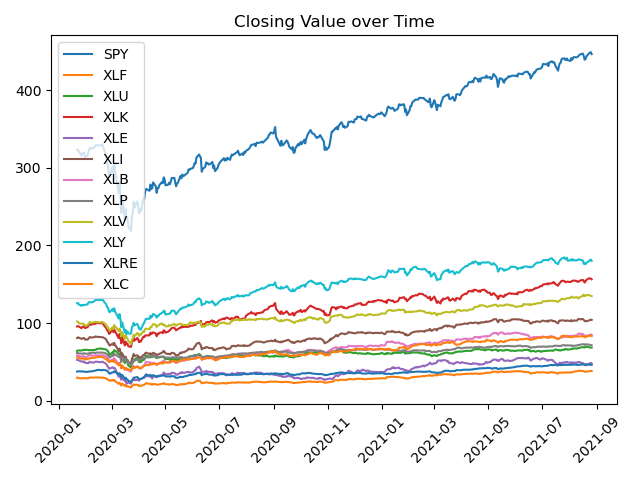

In [65]:
# test plotting with matplotlib
plt.figure()


for df in combo_list:
    plt.plot(df['Submission Date'], df['Close'], label=df['Ticker'][0])
    

plt.xticks(rotation=45)
plt.title('Closing Value over Time')
plt.legend()
plt.tight_layout()

In [26]:
# test plotting with pandas plots
#plt.figure()
axs = []

#for df in combo_list:
    #ax = df.plot.scatter(x='Submission Date', y='Volume')
    
#plt.title('Trade Volume Over Time')
#plt.legend()

# Couldn't really work it out satisfactorily

# some test plots for potential questions

<IPython.core.display.Javascript object>


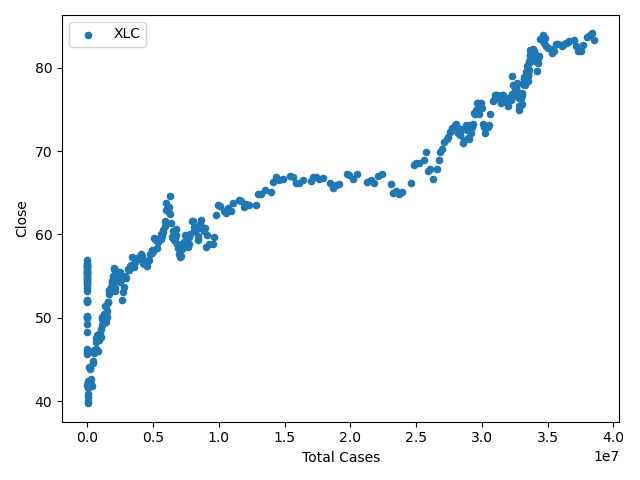

In [74]:
# total cases vs closing values
ind = 11
combo_list[ind].plot.scatter(x='Total Cases', y='Close', label=combo_list[ind]['Ticker'][0])
plt.tight_layout()

<IPython.core.display.Javascript object>


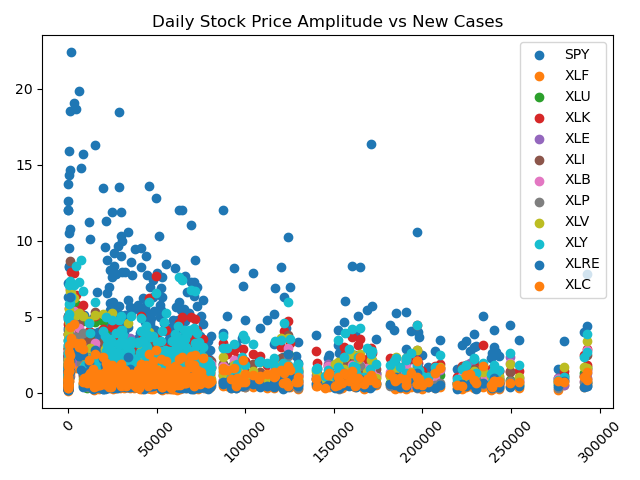

In [76]:
# amplitude vs new cases
plt.figure()


for df in combo_list:
    plt.scatter(df['Daily New Cases'], df['Amplitude'], label=df['Ticker'][0])
    

plt.xticks(rotation=45)
plt.title('Daily Stock Price Amplitude vs New Cases')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


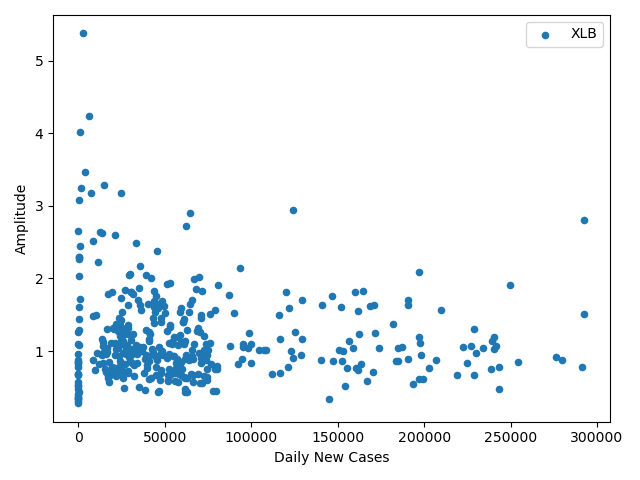

In [84]:
# individual: stock amplitude vs new cases
ind = 6
combo_list[ind].plot.scatter(x='Daily New Cases', y='Amplitude', label=combo_list[ind]['Ticker'][0])
plt.tight_layout()